# REAL DISTANCE APPROACH COMPARISON

In [46]:
# IMPORTS...
import pandas as pd
import random
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import itertools
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
# Data loading
from data_loading.gather_mat_files_multiple import gather_mat_files_multiple_condition
from data_loading.load_intervals import load_intervals_data
from data_loading.load_scores import load_scores_data
from data_loading.load_postprocessed import load_postprocessed_data

# Distance calculation
from distance_calculation.compute_distance_matrix import compute_distance_matrix
from distance_calculation.pick_n_representative import pick_n_representatives_simple
from distance_calculation.approach1_multi_hot import approach1_multi_hot_distance
from distance_calculation.approach5_simple_euclidean import approach5_simple_euclidean_distance
from distance_calculation.approach2_intervals import approach2_interval_distance
from distance_calculation.approach3_markov import approach3_markov_distance
from distance_calculation.approach4_scores import approach4_scores_distance
from distance_calculation.approach3_markov_pretrain import train_and_save_hmms_for_all_flies
from distance_calculation.approach3_markov_pretrain import build_distance_matrix_from_models

In [2]:
# Optimized data loading for real analysing. Bigger data sample.
base_folders = [
    r"D:\Ilya\Data\Females_Grouped",  # Contains 5 experiment datasets for Females Group (Grouped)
    r"D:\Ilya\Data\Females_Singles",  # Contains 5 experiment datasets for Females Singles (to be merged)
    r"D:\Ilya\Data\Males_Singles",  # Contains 5 experiment datasets for Males Singles
    r"D:\Ilya\Data\Males_Grouped"  # Contains 5 experiment datasets for Males Group
]

all_condition_files, condition_names = gather_mat_files_multiple_condition(base_folders)
print("Condition Names:")
print(condition_names)

Condition Names:
['Assa_Females_Grouped_Unknown_RigA_20220715T105702', 'Assa_Females_Grouped_Unknown_RigA_20220715T110325', 'Assa_Females_Grouped_Unknown_RigA_20220715T112156', 'Assa_Females_Grouped_Unknown_RigA_20220715T113506', 'Assa_Females_Grouped_Unknown_RigA_20220715T114244', 'Assa_Females_Singles_Unknown_RigA_20220714T105530', 'Assa_Females_Singles_Unknown_RigA_20220714T110522', 'Assa_Females_Singles_Unknown_RigA_20220714T111552', 'Assa_Females_Singles_Unknown_RigA_20220714T112714', 'Assa_Females_Singles_Unknown_RigA_20220714T113619', 'Assa_Males_Single_Unknown_RigA_20220714T105158', 'Assa_Males_Single_Unknown_RigA_20220714T110015', 'Assa_Males_Single_Unknown_RigA_20220714T110950', 'Assa_Males_Single_Unknown_RigA_20220714T112223', 'Assa_Males_Single_Unknown_RigA_20220714T113224', 'Assa_Males_Grouped_Unknown_RigA_20220207T080935', 'Assa_Males_Grouped_Unknown_RigA_20220207T082632', 'Assa_Males_Grouped_Unknown_RigA_20220207T083144', 'Assa_Males_Grouped_Unknown_RigA_20220207T084623'

In [3]:
# Load data
all_flies_post, post_index_map, post_cond_names = load_postprocessed_data(
    all_condition_files, single=False, condition_names=condition_names
)
all_flies_scores, scores_index_map, scores_cond_names = load_scores_data(
    all_condition_files, single=False, condition_names=condition_names
)
all_flies_intervals, intervals_index_map, intervals_cond_names = load_intervals_data(
    all_condition_files, single=False, condition_names=condition_names
)

In [14]:
print(post_index_map)

{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3), 4: (0, 4), 5: (0, 5), 6: (0, 6), 7: (0, 7), 8: (0, 8), 9: (0, 9), 10: (1, 0), 11: (1, 1), 12: (1, 2), 13: (1, 3), 14: (1, 4), 15: (1, 5), 16: (1, 6), 17: (1, 7), 18: (1, 8), 19: (1, 9), 20: (2, 0), 21: (2, 1), 22: (2, 2), 23: (2, 3), 24: (2, 4), 25: (2, 5), 26: (2, 6), 27: (2, 7), 28: (2, 8), 29: (2, 9), 30: (3, 0), 31: (3, 1), 32: (3, 2), 33: (3, 3), 34: (3, 4), 35: (3, 5), 36: (3, 6), 37: (3, 7), 38: (3, 8), 39: (3, 9), 40: (4, 0), 41: (4, 1), 42: (4, 2), 43: (4, 3), 44: (4, 4), 45: (4, 5), 46: (4, 6), 47: (4, 7), 48: (4, 8), 49: (4, 9), 50: (5, 0), 51: (5, 1), 52: (5, 2), 53: (5, 3), 54: (5, 4), 55: (5, 5), 56: (5, 6), 57: (5, 7), 58: (5, 8), 59: (5, 9), 60: (6, 0), 61: (6, 1), 62: (6, 2), 63: (6, 3), 64: (6, 4), 65: (6, 5), 66: (6, 6), 67: (6, 7), 68: (6, 8), 69: (6, 9), 70: (7, 0), 71: (7, 1), 72: (7, 2), 73: (7, 3), 74: (7, 4), 75: (7, 5), 76: (7, 6), 77: (7, 7), 78: (7, 8), 79: (7, 9), 80: (8, 0), 81: (8, 1), 82: (8, 2), 83: (8, 3), 8

In [4]:
# Prepare data
behavior_names_per_condition = []
import os

for cond_files in all_condition_files:
    names_for_this_cond = []
    for filepath in cond_files:
        base = os.path.basename(filepath)  # e.g. "scores_Grooming.mat"
        no_ext = os.path.splitext(base)[0]  # e.g. "scores_Grooming"
        parts = no_ext.split("_", 1)  # split on first underscore
        if len(parts) == 2:
            behavior_name = parts[1]  # e.g. "Grooming"
        else:
            behavior_name = no_ext
        names_for_this_cond.append(behavior_name)
    behavior_names_per_condition.append(names_for_this_cond)

export_data = {
    "postprocessed_data": all_flies_post,  # list of lists: each condition has a list of fly arrays
    "index_map": post_index_map,
    "condition_names": post_cond_names,
    "behavior_names_per_condition": behavior_names_per_condition
}

In [5]:

# Create empty lists for each merged group and new index mappings
fg_data = []  # Females_Grouped (conditions 0–4)
fs_data = []  # Females_Singles (conditions 5–9)
ms_data = []  # Males_Single (conditions 10–14)
mg_data = []  # Males_Grouped (conditions 15–19)

new_fg_index_map = {}  # new mapping: new index -> (group_id, local index)
new_fs_index_map = {}
new_ms_index_map = {}
new_mg_index_map = {}

# Iterate over each fly using the original index mapping.
# post_index_map: {global_idx: (cond_idx, local_fly_idx)}
for global_idx, (cond_idx, local_idx) in post_index_map.items():
    if cond_idx in {0, 1, 2, 3, 4}:
        new_local = len(fg_data)
        fg_data.append(all_flies_post[global_idx])
        new_fg_index_map[new_local] = (0, new_local)  # group 0: Females_Grouped
    elif cond_idx in {5, 6, 7, 8, 9}:
        new_local = len(fs_data)
        fs_data.append(all_flies_post[global_idx])
        new_fs_index_map[new_local] = (1, new_local)  # group 1: Females_Singles
    elif cond_idx in {10, 11, 12, 13, 14}:
        new_local = len(ms_data)
        ms_data.append(all_flies_post[global_idx])
        new_ms_index_map[new_local] = (2, new_local)  # group 2: Males_Single
    elif cond_idx in {15, 16, 17, 18, 19}:
        new_local = len(mg_data)
        mg_data.append(all_flies_post[global_idx])
        new_mg_index_map[new_local] = (3, new_local)  # group 3: Males_Grouped

# Confirm that each group has exactly 50 flies
print("Number of flies per group:")
print("Females_Grouped:", len(fg_data))
print("Females_Singles:", len(fs_data))
print("Males_Single:", len(ms_data))
print("Males_Grouped:", len(mg_data))

# We assume that for each group, all flies have identical behavior column names.
# For example, for Females_Grouped, pick the behavior names from the first file that contributed to group 0.
# The original behavior_names_per_condition is a list (length = number of original conditions, e.g., 20).
# Use:
#   group 0 (Females_Grouped): use behavior_names_per_condition[0]
#   group 1 (Females_Singles):   use behavior_names_per_condition[5]
#   group 2 (Males_Single):      use behavior_names_per_condition[10]
#   group 3 (Males_Grouped):     use behavior_names_per_condition[15]

behavior_names_fg = behavior_names_per_condition[0]  # from first Females_Grouped file
behavior_names_fs = behavior_names_per_condition[5]  # from first Females_Singles file
behavior_names_ms = behavior_names_per_condition[10]  # from first Males_Single file
behavior_names_mg = behavior_names_per_condition[15]  # from first Males_Grouped file

dfs_females_grouped = [
    pd.DataFrame(fly_data, columns=behavior_names_fg) for fly_data in fg_data
]
dfs_females_singles = [
    pd.DataFrame(fly_data, columns=behavior_names_fs) for fly_data in fs_data
]
dfs_males_single = [
    pd.DataFrame(fly_data, columns=behavior_names_ms) for fly_data in ms_data
]
dfs_males_grouped = [
    pd.DataFrame(fly_data, columns=behavior_names_mg) for fly_data in mg_data
]

all_exps_arrays = [
    [df.to_numpy() for df in dfs_females_grouped],
    [df.to_numpy() for df in dfs_females_singles],
    [df.to_numpy() for df in dfs_males_single],
    [df.to_numpy() for df in dfs_males_grouped]
]

print("Data conversion complete. Number of flies in each group:")
print("Females_Grouped:", len(all_exps_arrays[0]))
print("Females_Singles:", len(all_exps_arrays[1]))
print("Males_Single:", len(all_exps_arrays[2]))
print("Males_Grouped:", len(all_exps_arrays[3]))

# update the export_data dictionary with the merged groups and new index maps:
export_data_merged = {
    "postprocessed_data": [fg_data, fs_data, ms_data, mg_data],
    "index_map": [new_fg_index_map, new_fs_index_map, new_ms_index_map, new_mg_index_map],
    "group_names": ["Females_Grouped", "Females_Singles", "Males_Single", "Males_Grouped"],
    "behavior_names_per_group": [behavior_names_fg, behavior_names_fs, behavior_names_ms, behavior_names_mg]
}

Number of flies per group:
Females_Grouped: 50
Females_Singles: 50
Males_Single: 50
Males_Grouped: 50
Data conversion complete. Number of flies in each group:
Females_Grouped: 50
Females_Singles: 50
Males_Single: 50
Males_Grouped: 50


# Compute Intra/Inter Distance Ratios for Two Selected Groups

In [6]:
# Lets create better algorith for comparision of approaches, dont compare inter flies from one experimen for accuracy.
# Dont compare same flies again.
# Normalization helper same like in demo.
def normalize_distances(dist_list):
    arr = np.array(dist_list)
    if len(arr) == 0:
        return arr
    mn, mx = arr.min(), arr.max()
    if mx == mn:
        return arr
    return (arr - mn) / (mx - mn)

def compute_intra_inter_distances(all_exps, distance_func,
                                  n_pairs_intra=50, n_pairs_inter=50,
                                  trim_arrays=True):
    """
    Compute the normalized mean distances within groups (intra) and between groups (inter)
    and return their ratio.

    all_exps: list of experiments; each experiment is a list of fly data arrays.
    distance_func: function to compute distance between two fly data arrays.
    n_pairs_intra: max number of intra-group comparisons per experiment.
    n_pairs_inter: max number of inter-group comparisons overall.
    trim_arrays: whether to trim data arrays to the same length before comparison.
    """
    intra_dists = []  # distances from flies within the same experiment (group)
    inter_dists = []  # distances from flies between different experiments (groups)

    def trim_to_min_length(arr1, arr2):
        min_length = min(arr1.shape[0], arr2.shape[0])
        return arr1[:min_length], arr2[:min_length]

    # --- Intra-group comparisons ---
    for flies in all_exps:
        # Skip if fewer than 2 flies are present.
        if len(flies) < 2:
            continue

        # If there are more than 10 flies, partition into blocks of 10 so that comparisons
        # are only done between flies in different blocks.
        if len(flies) > 10:
            blocks = [flies[i:i+10] for i in range(0, len(flies), 10)]
            valid_pairs = []
            # Loop over all unique pairs of blocks.
            for b1 in range(len(blocks)):
                for b2 in range(b1 + 1, len(blocks)):
                    # Pair each fly from block b1 with each fly from block b2.
                    for flyA in blocks[b1]:
                        for flyB in blocks[b2]:
                            valid_pairs.append((flyA, flyB))
        else:
            # For groups with 10 or fewer flies, use all unique pairs.
            valid_pairs = list(itertools.combinations(flies, 2))

        # Shuffle pairs to randomize selection and take up to n_pairs_intra pairs.
        random.shuffle(valid_pairs)
        sampled_pairs = valid_pairs[:n_pairs_intra] if len(valid_pairs) > n_pairs_intra else valid_pairs

        # Compute distance for each selected pair.
        for flyA, flyB in sampled_pairs:
            if trim_arrays:
                flyA, flyB = trim_to_min_length(flyA, flyB)
            intra_dists.append(distance_func(flyA, flyB))

    # --- Inter-group comparisons ---
    # Generate all valid pairs from flies belonging to different experiments.
    valid_inter_pairs = []
    num_exps = len(all_exps)
    for i in range(num_exps):
        for j in range(i + 1, num_exps):
            exp_i = all_exps[i]
            exp_j = all_exps[j]
            # Skip if either experiment is empty.
            if not exp_i or not exp_j:
                continue
            # Pair each fly in one experiment with each fly in the other.
            for flyA in exp_i:
                for flyB in exp_j:
                    valid_inter_pairs.append((flyA, flyB))

    # Randomize and sample without repeats.
    random.shuffle(valid_inter_pairs)
    sampled_inter_pairs = (valid_inter_pairs[:n_pairs_inter]
                           if len(valid_inter_pairs) > n_pairs_inter
                           else valid_inter_pairs)

    for flyA, flyB in sampled_inter_pairs:
        if trim_arrays:
            flyA, flyB = trim_to_min_length(flyA, flyB)
        inter_dists.append(distance_func(flyA, flyB))

    # Normalize distances and compute mean values.
    intra_mean = normalize_distances(intra_dists).mean() if intra_dists else np.nan
    inter_mean = normalize_distances(inter_dists).mean() if inter_dists else np.nan
    ratio = intra_mean / inter_mean if (inter_mean and inter_mean != 0) else np.inf

    return intra_mean, inter_mean, ratio

"""
Algorithm Logic:

1. For each experimental group (list of flies):
   - If there are more than 10 flies, split the group into blocks of 10.
     This ensures that comparisons are only made between flies from different blocks.
     For example, the first 10 flies (block 1) will be compared with the remaining flies (blocks 2+),
     and so on.
   - If the group has 10 or fewer flies, compare all unique pairs.
   - Shuffle the valid intra-group pairs and select up to a specified number (n_pairs_intra) to avoid duplicates.
   - Compute the distance for each pair, optionally trimming the arrays to match in length.

2. For inter-group comparisons:
   - Generate all pairs where one fly comes from one experiment and the other fly from a different experiment.
   - Shuffle and select up to n_pairs_inter pairs to ensure no duplicate comparisons.

3. Normalize both the intra-group and inter-group distance lists to a [0, 1] range, then compute their means.
4. Return the ratio of the intra-group mean to the inter-group mean.
"""

'\nAlgorithm Logic:\n\n1. For each experimental group (list of flies):\n   - If there are more than 10 flies, split the group into blocks of 10.\n     This ensures that comparisons are only made between flies from different blocks.\n     For example, the first 10 flies (block 1) will be compared with the remaining flies (blocks 2+),\n     and so on.\n   - If the group has 10 or fewer flies, compare all unique pairs.\n   - Shuffle the valid intra-group pairs and select up to a specified number (n_pairs_intra) to avoid duplicates.\n   - Compute the distance for each pair, optionally trimming the arrays to match in length.\n\n2. For inter-group comparisons:\n   - Generate all pairs where one fly comes from one experiment and the other fly from a different experiment.\n   - Shuffle and select up to n_pairs_inter pairs to ensure no duplicate comparisons.\n\n3. Normalize both the intra-group and inter-group distance lists to a [0, 1] range, then compute their means.\n4. Return the ratio of t

In [18]:
# Selected groups: Females Singles (index 1) and Males Grouped (index 3)
selected_postprocessed = [ all_exps_arrays[1], all_exps_arrays[3] ]

In [7]:
# Prepare Scores DataFrames for the two selected groups
# For scores, use original scores_index_map to filter:
#   Females Singles: condition indices 5–9
#   Males Grouped:    condition indices 15–19
dfs_scores_females_singles = [
    pd.DataFrame(all_flies_scores[global_idx])
    for global_idx, (cond_idx, _) in scores_index_map.items()
    if cond_idx in {5, 6, 7, 8, 9}
]
dfs_scores_males_grouped = [
    pd.DataFrame(all_flies_scores[global_idx])
    for global_idx, (cond_idx, _) in scores_index_map.items()
    if cond_idx in {15, 16, 17, 18, 19}
]
selected_scores = [
    [df.to_numpy() for df in dfs_scores_females_singles],
    [df.to_numpy() for df in dfs_scores_males_grouped]
]

In [8]:
# For intervals, use original intervals_index_map to filter:
#   Females Singles: condition indices 5–9
#   Males Grouped:    condition indices 15–19
dfs_intervals_females_singles = [
    all_flies_intervals[global_idx]
    for global_idx, (cond_idx, _) in intervals_index_map.items()
    if cond_idx in {5, 6, 7, 8, 9} and len(all_flies_intervals[global_idx]) > 0
]
dfs_intervals_males_grouped = [
    all_flies_intervals[global_idx]
    for global_idx, (cond_idx, _) in intervals_index_map.items()
    if cond_idx in {15, 16, 17, 18, 19} and len(all_flies_intervals[global_idx]) > 0
]
selected_intervals = [
    [fly for fly in dfs_intervals_females_singles if fly],
    [fly for fly in dfs_intervals_males_grouped if fly]
]

In [71]:
# Hamming approach real iter-intro ratio
# Approach 1: Hamming Distance (using postprocessed data)
if selected_postprocessed:
    intra_a1, inter_a1, ratio_a1 = compute_intra_inter_distances(
        selected_postprocessed, approach1_multi_hot_distance,
        n_pairs_intra=2000, n_pairs_inter=2000,
        trim_arrays=True
    )
else:
    intra_a1, inter_a1, ratio_a1 = np.nan, np.nan, np.nan
results1 = pd.DataFrame({
    'Method': ['Approach1_Hamming'],
    'Avg Intra-Group': [intra_a1],
    'Avg Inter-Group': [inter_a1],
    'Ratio (Intra/Inter)': [ratio_a1]
})

In [70]:
# Euclidian approach real iter-intro ratio
# Approach 5: Euclidean Distance (using postprocessed data)
if selected_postprocessed:
    intra_a5, inter_a5, ratio_a5 = compute_intra_inter_distances(
        selected_postprocessed, approach5_simple_euclidean_distance,
        n_pairs_intra=2000, n_pairs_inter=2000,
        trim_arrays=True
    )
else:
    intra_a5, inter_a5, ratio_a5 = np.nan, np.nan, np.nan
results5 = pd.DataFrame({
    'Method': ['Approach5_Euclidean'],
    'Avg Intra-Group': [intra_a5],
    'Avg Inter-Group': [inter_a5],
    'Ratio (Intra/Inter)': [ratio_a5]
})

In [66]:
# Approach 3: Markov Distance (using scores data; comparisons reduced)
if selected_scores and all(len(exp) > 1 for exp in selected_scores):
    intra_a3, inter_a3, ratio_a3 = compute_intra_inter_distances(
        selected_scores, approach3_markov_distance,
        n_pairs_intra=20, n_pairs_inter=20,
        trim_arrays=True
    )
else:
    intra_a3, inter_a3, ratio_a3 = np.nan, np.nan, np.nan
results3 = pd.DataFrame({
    'Method': ['Approach3_HMM'],
    'Avg Intra-Group': [intra_a3],
    'Avg Inter-Group': [inter_a3],
    'Ratio (Intra/Inter)': [ratio_a3]
})

Model is not converging.  Current: 177602.78601765138 is not greater than 177605.98763710776. Delta is -3.2016194563766476
Model is not converging.  Current: 184847.0526959782 is not greater than 184847.23993750056. Delta is -0.18724152236245573
Model is not converging.  Current: 160450.17441324252 is not greater than 160450.2619324879. Delta is -0.08751924536773004
Model is not converging.  Current: 134950.4426522961 is not greater than 134950.46565089183. Delta is -0.022998595726676285
Model is not converging.  Current: 158174.00484953696 is not greater than 158175.772833593. Delta is -1.7679840560304
Model is not converging.  Current: 160553.7630642306 is not greater than 160553.83776690316. Delta is -0.07470267257303931
Model is not converging.  Current: 162114.56266551718 is not greater than 162114.58283139727. Delta is -0.02016588009428233
Model is not converging.  Current: 160553.76306708218 is not greater than 160553.83779917186. Delta is -0.07473208967712708
Model is not conve

In [76]:
# Intervals approach real iter-intro ratio
# Approach 2: Interval Distance (no trimming)
if selected_intervals and all(len(exp) > 1 for exp in selected_intervals):
    intra_a2, inter_a2, ratio_a2 = compute_intra_inter_distances(
        selected_intervals, approach2_interval_distance,
        n_pairs_intra=2000, n_pairs_inter=2000,
        trim_arrays=False
    )
else:
    intra_a2, inter_a2, ratio_a2 = np.nan, np.nan, np.nan
results2 = pd.DataFrame({
    'Method': ['Approach2_Intervals'],
    'Avg Intra-Group': [intra_a2],
    'Avg Inter-Group': [inter_a2],
    'Ratio (Intra/Inter)': [ratio_a2]
})


In [82]:
# DTW approach real iter-intro ratio
# Approach 4: DTW (using scores data)
if selected_scores:
    intra_a4, inter_a4, ratio_a4 = compute_intra_inter_distances(
        selected_scores, approach4_scores_distance,
        n_pairs_intra=100, n_pairs_inter=100,
        trim_arrays=True
    )
else:
    intra_a4, inter_a4, ratio_a4 = np.nan, np.nan, np.nan
results4 = pd.DataFrame({
    'Method': ['Approach4_DTW'],
    'Avg Intra-Group': [intra_a4],
    'Avg Inter-Group': [inter_a4],
    'Ratio (Intra/Inter)': [ratio_a4]
})

In [84]:
# All results table
all_results = pd.concat([results1, results2, results3, results4, results5], ignore_index=True)
print(all_results)

                Method  Avg Intra-Group  Avg Inter-Group  Ratio (Intra/Inter)
0    Approach1_Hamming         0.609251         0.619081             0.984122
1  Approach2_Intervals         0.440857         0.457357             0.963923
2        Approach3_HMM         0.050000         0.199297             0.250882
3        Approach4_DTW         0.500802         0.391502             1.279182
4  Approach5_Euclidean         0.651924         0.666268             0.978471


In [12]:
# Usage with all_flies_scores
#all_flies_scores = [...]  # list of (T, B) arrays, e.g. length=200
save_folder = r"D:\Ilya\Data\GaussianHMM"

# 1) Train a model for a single fly: (n_hidden_states=5, n_iter=100)
# train_and_save_gaussian_hmm(all_flies_scores[0], 0, save_folder)

# 2) Train & save for all flies in a loop, skipping already saved models.
train_and_save_hmms_for_all_flies(all_flies_scores, save_folder,
                                    n_hidden_states=8,
                                    n_iter=150, tol=1e-3,
                                    covariance_type='full')

# 3) Build a distance matrix from saved models.
n_flies = len(all_flies_scores)
dist_mat = build_distance_matrix_from_models(save_folder, n_flies)
print("Distance matrix shape:", dist_mat.shape)

Training model for Fly 0...


Model is not converging.  Current: 178135.8762943811 is not greater than 178136.07212778422. Delta is -0.1958334031223785


...Saved model for Fly 0 (file: D:\Ilya\Data\GaussianHMM\fly_0.pkl).
Training model for Fly 1...


Model is not converging.  Current: 184187.18650841745 is not greater than 184187.31889947676. Delta is -0.13239105930551887


...Saved model for Fly 1 (file: D:\Ilya\Data\GaussianHMM\fly_1.pkl).
Training model for Fly 2...
...Saved model for Fly 2 (file: D:\Ilya\Data\GaussianHMM\fly_2.pkl).
Fly 3: model already saved. Skipping.
Fly 4: model already saved. Skipping.
Fly 5: model already saved. Skipping.
Fly 6: model already saved. Skipping.
Fly 7: model already saved. Skipping.
Fly 8: model already saved. Skipping.
Fly 9: model already saved. Skipping.
Fly 10: model already saved. Skipping.
Fly 11: model already saved. Skipping.
Fly 12: model already saved. Skipping.
Fly 13: model already saved. Skipping.
Fly 14: model already saved. Skipping.
Fly 15: model already saved. Skipping.
Fly 16: model already saved. Skipping.
Fly 17: model already saved. Skipping.
Fly 18: model already saved. Skipping.
Fly 19: model already saved. Skipping.
Fly 20: model already saved. Skipping.
Fly 21: model already saved. Skipping.
Fly 22: model already saved. Skipping.
Fly 23: model already saved. Skipping.
Fly 24: model already 

C:\Users\labophir\AppData\Local\Temp\ipykernel_7356\4024366693.py:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mahal = float(diff.T @ invSigma2 @ diff)


Distance matrix shape: (200, 200)


# SIMPLE FLY ANALYSING USING DISTANCE APPROACHES

# Clustering

[[ 0.00000000e+00  9.81497451e+05 -1.11760764e+15 ...  1.94294872e+06
   9.29512211e+05  4.13014503e+05]
 [ 9.81497451e+05  0.00000000e+00 -5.85339955e+15 ...  7.27947347e+05
   2.71748825e+05  1.67015652e+05]
 [-1.11760764e+15 -5.85339955e+15  0.00000000e+00 ...  6.19740385e+15
  -1.57405946e+15 -3.72729365e+15]
 ...
 [ 1.94294872e+06  7.27947347e+05  6.19740385e+15 ...  0.00000000e+00
   9.62415697e+05  1.13605624e+06]
 [ 9.29512211e+05  2.71748825e+05 -1.57405946e+15 ...  9.62415697e+05
   0.00000000e+00  1.76438156e+05]
 [ 4.13014503e+05  1.67015652e+05 -3.72729365e+15 ...  1.13605624e+06
   1.76438156e+05  0.00000000e+00]]


In [20]:
# Preparing
#       cond_idx 0–4  → Females_Grouped (50 flies)
#       cond_idx 5–9  → Females_Singles (50 flies)
#       cond_idx 10–14 → Males_Single    (50 flies)
#       cond_idx 15–19 → Males_Grouped   (50 flies)

# Create indices for each original condition:
indices_fg = [i for i, (cond, _) in scores_index_map.items() if cond in set(range(0, 5))]
indices_fs = [i for i, (cond, _) in scores_index_map.items() if cond in set(range(5, 10))]
indices_ms = [i for i, (cond, _) in scores_index_map.items() if cond in set(range(10, 15))]
indices_mg = [i for i, (cond, _) in scores_index_map.items() if cond in set(range(15, 20))]

# Create merged groups:
overall_females = indices_fg + indices_fs   # 50 + 50 = 100 flies
overall_males   = indices_ms + indices_mg     # 50 + 50 = 100 flies
overall_singles = indices_fs + indices_ms     # 50 + 50 = 100 flies
overall_groups  = indices_fg + indices_mg     # 50 + 50 = 100 flies

# Build a dictionary mapping group names to lists of indices:
groups_index_map = {
    "Females_Grouped": indices_fg,
    "Females_Singles": indices_fs,
    "Males_Single":    indices_ms,
    "Males_Grouped":   indices_mg,
    "Overall_Females": overall_females,
    "Overall_Males":   overall_males
}

# Optionally, print the group indices and total counts:
for group_name, idx_list in groups_index_map.items():
    print(f"{group_name} ({len(idx_list)} flies): {idx_list}")


Females_Grouped (50 flies): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Females_Singles (50 flies): [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Males_Single (50 flies): [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
Males_Grouped (50 flies): [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]

In [22]:
###############################################################################
# PART 2: Build a function to compute robust similarity for each group
###############################################################################

def robust_similarity_for_group(dist_mat, indices, outlier_frac=0.1):
    """
    Computes a robust similarity measure (median pairwise distance among inliers)
    for a given group from a larger distance matrix.

    dist_mat: (N x N) distance matrix for all flies
    indices: list of fly indices belonging to this group
    outlier_frac: fraction of outliers to remove (top % by MDS-centroid distance)

    Returns: float robust similarity measure (lower => more similar)
    """
    if len(indices) < 2:
        return np.nan

    # Extract sub-matrix for these flies
    sub_mat = dist_mat[np.ix_(indices, indices)]
    N_sub = len(indices)

    # MDS to embed in 2D
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(sub_mat)

    # Compute centroid & distance from centroid
    centroid = np.mean(coords, axis=0)
    dists = np.linalg.norm(coords - centroid, axis=1)

    # Filter out top outlier_frac
    threshold = np.percentile(dists, 100*(1-outlier_frac))
    inlier_mask = (dists <= threshold)
    if np.sum(inlier_mask) < 2:
        inlier_mask = np.ones_like(inlier_mask, dtype=bool)

    # Median pairwise distance among inliers
    sub_inlier = sub_mat[np.ix_(inlier_mask, inlier_mask)]
    triu_indices = np.triu_indices_from(sub_inlier, k=1)
    robust_sim = np.median(sub_inlier[triu_indices])
    return robust_sim

In [30]:
###############################################################################
# 1. Define a function to transform and plot the distance matrix with clustering.
###############################################################################

def plot_mds_kmeans_custom_scaled(df_distance, groups_index_map, title="MDS + KMeans (6 clusters)"):
    """
    Plots an MDS embedding of the distance matrix after applying a scaling transformation,
    then clusters the embedded points with KMeans (6 clusters). Each point is colored by
    its true group (from groups_index_map) and marked with a shape corresponding to its
    predicted cluster.

    Parameters:
      df_distance      : a pandas DataFrame (200×200) containing the raw distance matrix.
      groups_index_map : dict mapping true group names to lists of fly indices.
                         For example:
                         {
                           "Females_Grouped": [...],
                           "Females_Singles": [...],
                           "Males_Single":    [...],
                           "Males_Grouped":   [...],
                           "Overall_Females": [...],
                           "Overall_Males":   [...]
                         }
      title            : Title for the plot.
    """
    # Get the raw distance matrix.
    dist_mat = df_distance.values.copy()

    # --- Distance Matrix Scaling ---
    # Shift if negative values exist.
    min_val = np.min(dist_mat)
    offset = -min_val if min_val < 0 else 0
    dist_mat_adj = dist_mat + offset
    # Apply logarithmic compression.
    dist_mat_transformed = np.log1p(dist_mat_adj)

    # --- Improved MDS Embedding ---
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42,
              n_init=10, metric=True)
    coords_2d = mds.fit_transform(dist_mat_transformed)

    # --- KMeans Clustering with 6 clusters ---
    kmeans = KMeans(n_clusters=6, random_state=42)
    cluster_labels = kmeans.fit_predict(coords_2d)

    # --- Build a mapping from fly index to true group ---
    fly_to_group = {}
    for group_name, idx_list in groups_index_map.items():
        for idx in idx_list:
            fly_to_group[idx] = group_name

    # Define a color mapping for true groups.
    group_color_map = {
        "Females_Grouped": "red",
        "Females_Singles": "blue",
        "Males_Single":    "green",
        "Males_Grouped":   "orange",
        "Overall_Females": "magenta",
        "Overall_Males":   "cyan"
    }
    # Define a shape mapping for predicted cluster labels.
    cluster_shape_map = {
        0: 'o',
        1: 's',
        2: '^',
        3: 'd',
        4: 'p',
        5: 'v'
    }

    # --- Plotting ---
    plt.figure(figsize=(12, 8))
    for i in range(len(df_distance)):
        true_group = fly_to_group.get(i, "Unknown")
        color = group_color_map.get(true_group, "black")
        shape = cluster_shape_map.get(cluster_labels[i], 'o')
        plt.scatter(coords_2d[i, 0], coords_2d[i, 1],
                    c=color, marker=shape, s=40, alpha=0.6, edgecolor='k')
        plt.text(coords_2d[i, 0] + 0.01, coords_2d[i, 1] + 0.01, f"{i}", fontsize=8)
    plt.title(title)
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.grid(True)
    plt.show()


Robust Similarity Measures (lower = more homogeneous):
             Group  Robust Similarity  Normalized Similarity
0  Females_Grouped      700046.905655             100.000000
1  Females_Singles      432185.349960              61.736627
2     Males_Single      448506.417576              64.068052
3    Males_Grouped      523179.413957              74.734908
4  Overall_Females      548455.978982              78.345604
5    Overall_Males      498211.699588              71.168331


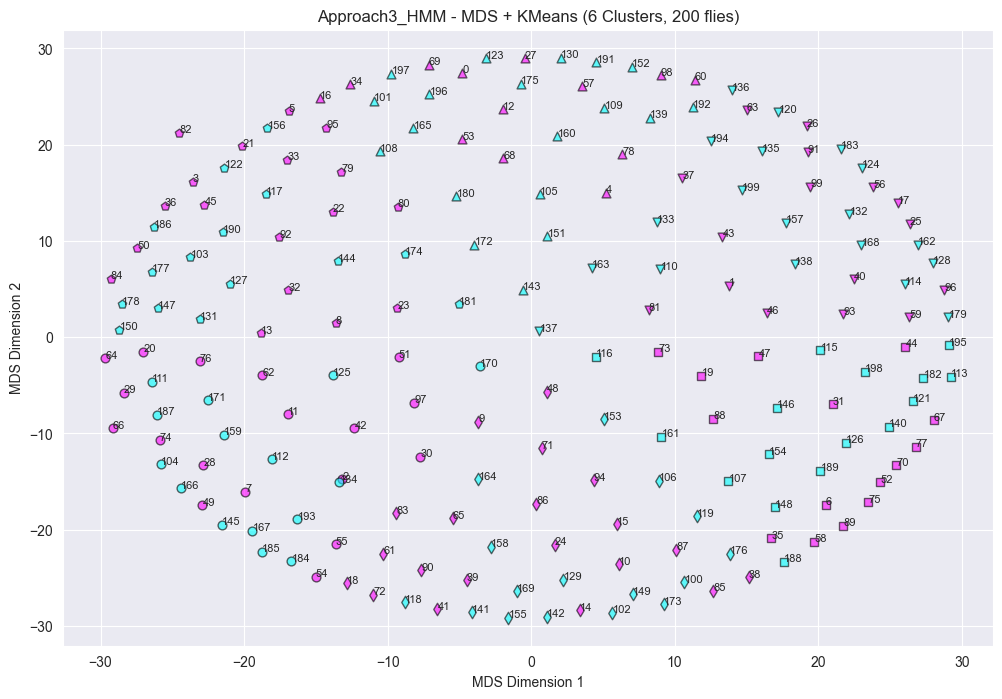

In [31]:
# 1) Calculate robust similarity per group
results = []
similarities = []

for gname, idx_list in groups_index_map.items():
    sim = robust_similarity_for_group(dist_mat, idx_list, outlier_frac=0.1)
    similarities.append(sim)
    results.append({"Group": gname, "Robust Similarity": sim})

# Normalize similarities by the maximum value only
max_sim = max(similarities) if similarities else 1  # Avoid division by zero
df_results = pd.DataFrame(results)

df_results["Normalized Similarity"] = df_results["Robust Similarity"].apply(
    lambda x: (x / max_sim) * 100 if max_sim != 0 else 0
)

# Print results
print("Robust Similarity Measures (lower = more homogeneous):")
print(df_results)

# 2) Convert dist_mat to DataFrame and run MDS+KMeans with color/shape
df_distance = pd.DataFrame(dist_mat)

plot_mds_kmeans_custom_scaled(df_distance, groups_index_map,
                                title="Approach3_HMM - MDS + KMeans (6 Clusters, 200 flies)")

In [ ]:
############################

In [44]:
def normalize_distances(dist_list):
    arr = np.array(dist_list)
    if len(arr) == 0:
        return arr
    mn, mx = arr.min(), arr.max()
    if mx == mn:
        return arr
    return (arr - mn) / (mx - mn)

def compute_intra_inter_from_dist_matrix(dist_mat, indices_group1, indices_group2,
                                           n_pairs_intra=50, n_pairs_inter=50):
    """
    Computes the mean normalized intra-group distance and mean normalized inter-group distance
    from a precomputed distance matrix, then returns their ratio.

    Parameters:
      dist_mat       : NxN numpy array (precomputed distance matrix).
      indices_group1 : list of indices for group 1.
      indices_group2 : list of indices for group 2.
      n_pairs_intra  : maximum number of intra-group comparisons per group.
      n_pairs_inter  : maximum number of inter-group comparisons.

    Returns:
      intra_mean: normalized mean intra-group distance (averaged over both groups).
      inter_mean: normalized mean inter-group distance.
      ratio     : intra_mean / inter_mean (if inter_mean > 0, else np.inf).
    """
    intra_dists = []
    inter_dists = []

    # Intra-group comparisons for Group1
    pairs_g1 = list(itertools.combinations(indices_group1, 2))
    if len(pairs_g1) > n_pairs_intra:
        sampled_g1 = random.sample(pairs_g1, n_pairs_intra)
    else:
        sampled_g1 = pairs_g1
    for (i, j) in sampled_g1:
        intra_dists.append(dist_mat[i, j])

    # Intra-group comparisons for Group2
    pairs_g2 = list(itertools.combinations(indices_group2, 2))
    if len(pairs_g2) > n_pairs_intra:
        sampled_g2 = random.sample(pairs_g2, n_pairs_intra)
    else:
        sampled_g2 = pairs_g2
    for (i, j) in sampled_g2:
        intra_dists.append(dist_mat[i, j])

    # Inter-group comparisons: all pairs between group1 and group2
    inter_pairs = [(i, j) for i in indices_group1 for j in indices_group2]
    if len(inter_pairs) > n_pairs_inter:
        sampled_inter = random.sample(inter_pairs, n_pairs_inter)
    else:
        sampled_inter = inter_pairs
    for (i, j) in sampled_inter:
        inter_dists.append(dist_mat[i, j])

    # Normalize the distances for intra and inter comparisons
    intra_norm = normalize_distances(intra_dists)
    inter_norm = normalize_distances(inter_dists)

    intra_mean = intra_norm.mean() if len(intra_norm) > 0 else np.nan
    inter_mean = inter_norm.mean() if len(inter_norm) > 0 else np.nan
    ratio = intra_mean / inter_mean if inter_mean and inter_mean != 0 else np.inf
    return intra_mean, inter_mean, ratio

###############################################################################
# Example Execution for Two Groups:
# Females Singles: condition indices 5–9
# Males Grouped:    condition indices 15–19
###############################################################################

# Assume:
# - dist_mat is our precomputed 200x200 distance matrix (numpy array).
# - scores_index_map is a dict mapping global fly index to (cond_idx, local_fly_idx).
#   For scores:
#       cond_idx in {5,6,7,8,9} → Females Singles (50 flies)
#       cond_idx in {15,16,17,18,19} → Males Grouped (50 flies)

# Create indices for Females Singles and Males Grouped from scores_index_map:
indices_fs = [i for i, (cond, _) in scores_index_map.items() if cond in {5,6,7,8,9}]
indices_mg = [i for i, (cond, _) in scores_index_map.items() if cond in {15,16,17,18,19}]

# Now compute the intra/inter distances and ratio using the precomputed dist_mat:
intra_mean, inter_mean, ratio = compute_intra_inter_from_dist_matrix(
    dist_mat, indices_fs, indices_mg, n_pairs_intra=2500, n_pairs_inter=2500
)

print("Intra-group mean (normalized):", intra_mean)
print("Inter-group mean (normalized):", inter_mean)
print("Ratio (Intra/Inter):", ratio)


Intra-group mean (normalized): 0.011976434735138911
Inter-group mean (normalized): 0.028532610376546506
Ratio (Intra/Inter): 0.4197454974180494


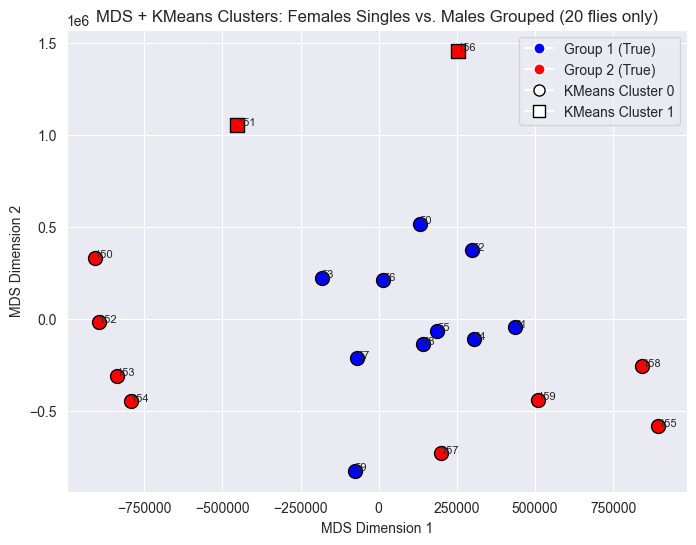

In [56]:
def plot_mds_kmeans_subset(dist_mat, indices_group1, indices_group2, n_subgroup=5, title="MDS + KMeans Clusters"):
    """
    Visualize clustering for two groups using MDS and KMeans.
    Only n_subgroup flies are taken from each group to limit the total points.

    Parameters:
      dist_mat      : full NxN distance matrix (numpy array).
      indices_group1: list of indices for group 1 (e.g., up to 50).
      indices_group2: list of indices for group 2 (e.g., up to 50).
      n_subgroup    : how many flies to select from each group. (e.g. 5 => total 10)
      title         : Plot title.
    """
    # 1) Subset each group to n_subgroup flies.
    #    If the group is smaller than n_subgroup, take the entire group.
    g1_subset = indices_group1[:n_subgroup]
    g2_subset = indices_group2[:n_subgroup]

    # 2) Combine them.
    subset_indices = g1_subset + g2_subset
    # Build sub-distance matrix
    sub_dist_mat = dist_mat[np.ix_(subset_indices, subset_indices)]

    # 3) MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, n_init=10)
    coords_2d = mds.fit_transform(sub_dist_mat)

    # 4) K-Means with 2 clusters
    kmeans = KMeans(n_clusters=2, random_state=42)
    cluster_labels = kmeans.fit_predict(coords_2d)

    # 5) Color and shape mapping
    #    Group1: Blue, Group2: Red
    color_map = [("blue" if idx in g1_subset else "red") for idx in subset_indices]
    #    KMeans label => shape
    shape_map = ['o' if lbl == 0 else 's' for lbl in cluster_labels]

    # 6) Plot
    plt.figure(figsize=(8,6))
    for i, global_idx in enumerate(subset_indices):
        x, y = coords_2d[i]
        plt.scatter(x, y, c=color_map[i], marker=shape_map[i], s=100, edgecolor='black')
        plt.text(x+0.01, y+0.01, str(global_idx), fontsize=8)

    # 7) Legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
               markersize=8, label="Group 1 (True)"),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
               markersize=8, label="Group 2 (True)"),
        Line2D([0], [0], marker='o', color='w', markeredgecolor='black',
               markersize=8, label="KMeans Cluster 0"),
        Line2D([0], [0], marker='s', color='w', markeredgecolor='black',
               markersize=8, label="KMeans Cluster 1")
    ]
    plt.legend(handles=legend_elements, loc="best")
    plt.title(title)
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.grid(True)
    plt.show()

# ---------------------------------------------------------------------------
# Example usage:
#   dist_mat: 200x200 array
#   indices_fs: Females Singles (50 indices)
#   indices_mg: Males Grouped (50 indices)
#   We want 5 from each => total 10 points.

plot_mds_kmeans_subset(dist_mat, indices_fs, indices_mg,
    n_subgroup=10,
    title="MDS + KMeans Clusters: Females Singles vs. Males Grouped (20 flies only)")
